# NO input files for CESM

### Explore the 3 NO input files
### Then increase the soil flux over the Amazon



In [1]:
import netCDF4 as nc4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import datetime
import scipy

import xarray as xr

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [2]:
datapath='/eos18/aswann/Macrosystems_ecoclimtel_test/CLM_transient_land_use/'

In [3]:
NO_anthro ='emissions-cmip6_NO_anthro_surface_1750-2015_0.9x1.25_c20170608.nc'
NO_bb     ='emissions-cmip6_NO_bb_surface_1750-2015_0.9x1.25_c20180611.nc'
NO_other  ='emissions-cmip6_NO_other_surface_1750-2015_0.9x1.25_c20170322.nc'

In [4]:
ds_anthro = xr.open_dataset(datapath +NO_anthro)
ds_bb = xr.open_dataset(datapath +NO_bb)
ds_other = xr.open_dataset(datapath +NO_other)

# get the value for the last year in the dataset
lastyear=ds_other.time[-1]

## Explore existing NO flux input files

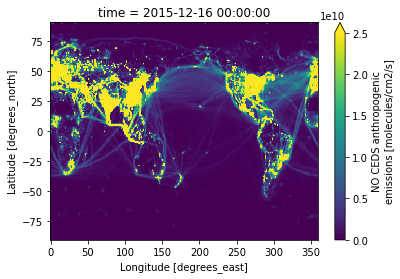

In [5]:
ds_anthro.emiss_anthro[-1,:,:].plot(vmin=0,vmax=0.25e11)

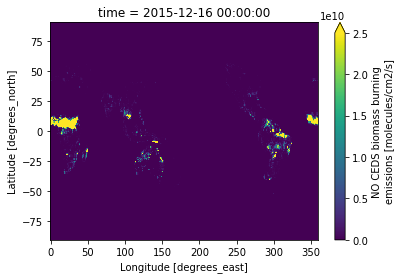

In [6]:
ds_bb.emiss_bb[-1,:,:].plot(vmin=0,vmax=0.25e11)

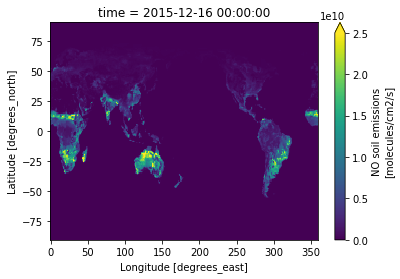

In [7]:
ds_other.emiss_soils[-1,:,:].plot(vmin=0,vmax=2.5e10)

## Now lets modify one of the input files to increase NO flux

In [8]:
# define file name for modified NO flux input file
NO_other_30x_filename = 'emissions-cmip6_NO_other_surface_1750-2015_0.9x1.25_c20170322_30xincrease.nc'

NO_other_30x_export=ds_other.copy()

## Define the "Amazon" region
We are going to increase NO flux from soils in one region only  
Define the bounds of that region

#### Amazon
Latitude: -16 to 8  
Longitude: -88 to -12 

In [9]:
Amazon_lat_min = -16
Amazon_lat_max = 8

Amazon_lon_min = 360-78
Amazon_lon_max = 360-48

#### We will attempt to use the region that has tropical forest to define the region for increasing NO
load the pft input file and find natpft=4

In [10]:
# The 78 pft file attempting to use with FCfireHIST compset
datalocation='/home/disk/eos18/aswann/Macrosystems_ecoclimtel_test/CLM_transient_land_use/'
transientfilename='landuse.timeseries_0.9x1.25_hist_78pfts_simyr1850-2015_c170428.nc'

# open the transient land use file 
ds=xr.open_dataset(datalocation +transientfilename)


In [11]:
# for some reason, these transient land use files don't have values for lsmlat and lsmlon defined 
# we can extract them from the dataset:
#lon = ds.LONGXY[0,:].values
#lat = ds.LATIXY[:,0].values 

# but because we are trying to use this to match another input file *exactly* we will use those lats and lons instead
# the difference is 1e-6
lon = ds_other.lon.values
lat = ds_other.lat.values 

# and add them back into the definition of the dimensions
ds_transient=ds.assign_coords(lsmlat = lat, lsmlon = lon)

ds_transient=ds_transient.rename({'lsmlat': 'lat','lsmlon': 'lon'})

#ds_transient

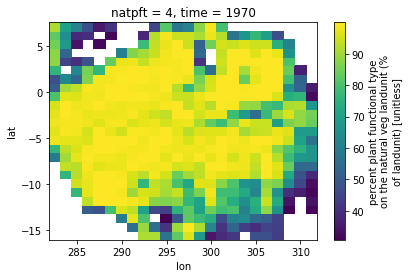

In [12]:
# Amazon freeze year is 1970
AmazonFreezeYear = 1970

#--- this is the map of land use that we will want to hold fixed for all years after the Freeze Date
Amazon_forest_pft4=ds_transient.PCT_NAT_PFT.sel(time=AmazonFreezeYear,lat=slice(Amazon_lat_min,Amazon_lat_max),
                             lon=slice(Amazon_lon_min,Amazon_lon_max),natpft=4)

##--- trying to select only places in the Amazon where pft4 has greater than 30% of the gridcell
#Amazon_forest=ds_transient.sel(time=AmazonFreezeYear,lat=slice(Amazon_lat_min,Amazon_lat_max),
#                             lon=slice(Amazon_lon_min,Amazon_lon_max))

# plot only locations where Amazon pft4 has greater than 30% of gridcell
Amazon_forest_pft4.where(Amazon_forest_pft4>30).plot()

treemask=Amazon_forest_pft4.where(Amazon_forest_pft4>30)

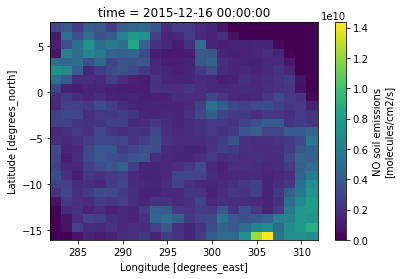

In [14]:
# plot check original data
ds_other.emiss_soils.sel(time=lastyear,lat=slice(Amazon_lat_min,Amazon_lat_max),
                             lon=slice(Amazon_lon_min,Amazon_lon_max)).plot()

#convert the units to mg m-2 h-1
# 1 molec cm-2 s-1 = 8.4e-10 ug m-2 hr-1
unitconvert = 8.4e-10 

### How much to increase NO flux?

the Keller paper uses units of ng cm-2 hr-1. To convert that to ug m-2 hr-1, you multiply by 10. Note in their Table 1 for undistrubed forest, NO fluxes can range from 20 to 150 ug m-2 hr-1. Fluxes are even higher in logged sites, see Tables 3 and 4 (250 to 450 ug m-2 hr-1 in the annual mean).


There are many studies (here is one example, https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2000GB001349, see figure 2) that report soil NO fluxes (up to 30 um m-2 hr-1 in forest, 7.5 in pasture) but perhaps we use Keller paper for now and multiply our current model NO soil flux by 5 to 10?



In [ ]:
#convert the units to mg m-2 h-1
# 1 molec cm-2 s-1 = 8.4e-10 ug m-2 hr-1
unitconvert = 8.4e-10 

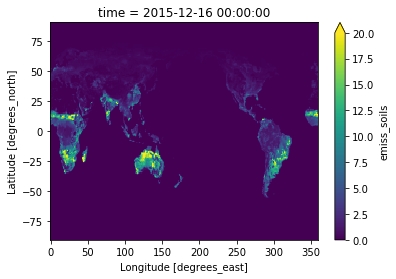

In [20]:
# plot soil emissions in a different unit

(ds_other.emiss_soils[-1,:,:]*unitconvert).plot(vmin=0,vmax=20)

<xarray.DataArray 'emiss_soils' (time: 3192, lat: 25, lon: 24)>
[1915200 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 282.5 283.75 285.0 286.25 ... 308.75 310.0 311.25
  * lat      (lat) float32 -15.549738 -14.607329 ... 6.125654 7.068063
  * time     (time) object 1750-01-16 00:00:00 ... 2015-12-16 00:00:00
Attributes:
    units:             molecules/cm2/s
    long_name:         NO soil emissions
    molecular_weight:  30.0

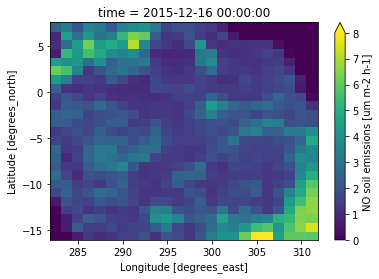

In [32]:
#--- create a subset that is just the Amazon
Amazon_NO=ds_other.emiss_soils.sel(lat=slice(Amazon_lat_min,Amazon_lat_max),
                             lon=slice(Amazon_lon_min,Amazon_lon_max))

(Amazon_NO.sel(time=lastyear)*unitconvert).plot(vmin=0,vmax=8, cbar_kwargs={'label': 'NO soil emissions [um m-2 h-1]'})

Amazon_NO

In [33]:
#--- create a subset that is just the Amazon and increase the value by a factor over forested areas
factor=10

Amazon_NO_30x=ds_other.emiss_soils.sel(lat=slice(Amazon_lat_min,Amazon_lat_max),
                             lon=slice(Amazon_lon_min,Amazon_lon_max))*factor

# use the Amazon_NO_30x datset everywhere treemask>0, and the original Amazon_NO where treemask<0
Amazon_NO_30x=Amazon_NO_30x.where(treemask>0,Amazon_NO)



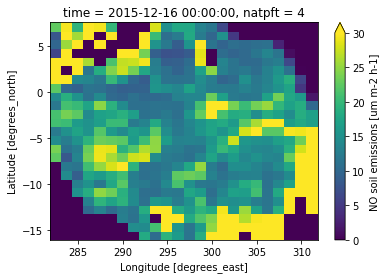

In [34]:
# plot check the 30x increase over the Amazon
((Amazon_NO_30x.sel(time=lastyear)-Amazon_NO.sel(time=lastyear))*unitconvert).plot(vmin=0,vmax=30, cbar_kwargs={'label': 'NO soil emissions [um m-2 h-1]'})
#Amazon_NO_30x_umm2hr.sel(time=lastyear).plot()

In [25]:
ds_NO_other_30x=ds_other.emiss_soils.copy()

# assign the land use map that is constant in our focus region from our freeze year into every year after the freeze year
# using .loc and a dict to broadcast our 2D array into the 3D dataset
ds_NO_other_30x.loc[dict(lat=slice(Amazon_lat_min,Amazon_lat_max), 
                         lon=slice(Amazon_lon_min,Amazon_lon_max))] = Amazon_NO_30x

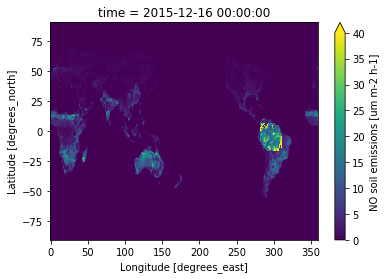

In [35]:
(ds_NO_other_30x.sel(time=lastyear)*unitconvert).plot(vmin=0,vmax=40, cbar_kwargs={'label': 'NO soil emissions [um m-2 h-1]'})

In [ ]:
# modify our custom copy of the transient emissions file
NO_other_30x_export.drop(labels='emiss_soils')
NO_other_30x_export = NO_other_30x_export.assign(emiss_soils=ds_NO_other_30x)

## Save modified file

In [ ]:
# Save the modified file
NO_other_30x_export.to_netcdf(datapath +NO_other_30x_filename)

